# useful functions

## coding the functions

### modules we are going to need

In [1]:
from scipy import *
from pylab import *

import wave
import struct
import subprocess

import scipy.misc as sm
import matplotlib.pyplot as plt

%matplotlib inline

### image -> sample

In [2]:
def getCoeff(freq):
        
        # FALLUNTERSCHEIDUNG FEHLT !!!
        # freq muss gerade sein!
        
    l = size(freq)
    
    a = zeros(l//2+1)
    b = zeros(l//2+1)
    
    for k in range(l//2):
        b[-(k+1)] = freq[k]
        a[k] = freq[k+l//2]
        
    return a,b
    

In [3]:
def freqToSampleNaive(freq, duration, framerate = 44100):
    
    a,b = getCoeff(freq)
    l = size(freq)
        
    sampleLength = duration * framerate    
    time = linspace(0,duration,sampleLength)
    
    samples = []
    
    for n in time:
        sum = a[0]/2
        for k in range(1,l//2+1):
            sum += a[k]*cos(k*n/framerate)+b[k]*sin(k*n/framerate)
            
        samples.append(sum)
        
    return samples

### sample <-> sound

In [4]:
def sampleToSound(sample, framerate = 44100, name = 'sample.wav'):
    
    string = 'rm ' + name
    subprocess.call(string, shell=True)
    cp = wave.open( name , 'w')
    
    cp.setparams((1, 2, framerate, 0, 'NONE', 'not compressed'))
    
    values = []
    
    for k in range(len(sample)):                    
        value = int(sample[k])                      
        packed_value = struct.pack('h', value)      
        values.append(packed_value)
        
    value_str = bytes().join(values)
    cp.writeframes(value_str)
                
        
    cp.close()

In [5]:
def soundToSample(filename):
    wf = wave.open(filename,'r')
    
    channel = wf.getnchannels()
    framerate = wf.getframerate()
    
    sample = []
    tmp = wf.readframes(1)

    if channel == 1:
        while tmp != '' :                           # sollte wf.getnframes() mal durchlaufen werden
            data = struct.unpack('h', tmp)
            sample.append(int(data[0]))
            tmp = wf.readframes(1)
            
    else:
        while tmp != '' :                       
            data = struct.unpack('hh', tmp)
            sample.append(int((data[0]+data[1])/2)) # bei Stereo werden linker und rechter Sound gemittelt
            tmp = wf.readframes(1)
        
    wf.close()
    
    return sample, framerate

## testing the functions

### $getCoeff$

Suppose you've already extracted the entries of an image via a proper Hilbert curve.
You end up with an array $freq$ which we can now interpret as the frequencies of a piece of music.
For the sake of simplicity let's say our $freq$ is given by:

In [6]:
freq = arange(1,(2**2)**2+1)
freq

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

which would correspond to a $2^2 \times 2^2$ image.

Thinking of this array as $freq = (b_n, \dots , b_1, a_0, a_1, \dots , a_{n-1})$ yields:

In [7]:
a,b = getCoeff(freq)
b,a

(array([ 0.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.]),
 array([  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,   0.]))

where we set $b_0 = a_n = 0$.

### $freqToSampleNaive$ - theory

Assuming our sound can be modeled by an (integrable) real valued function $f \colon \mathbb{R}^+ \rightarrow \mathbb{R}$, we know that it can be recovered from its Fourier coefficients by
$$f(x) = \frac{a_a}{2} + \sum_{k = 1}^{\infty} a_k \, cos(kx) + b_k \, sin(kx)$$

Sampling this function on a bunch of equidistant points $(p_i)_{i=0}^N$ starting with $p_0 = 0$ gives us a new descrete function $s \colon \mathbb{N}_{\leq N} \rightarrow \mathbb{R}$ defined by
$$s(n) := f(p_n) = \frac{a_a}{2} + \sum_{k = 1}^{\infty} a_k \, cos(kp_n) + b_k \, sin(kp_n)$$

We call $s$ the sample array of our sound $f$ or simply our samples, $s(n)$ is called the $n$-th sample and $N$ will be the sample length. Since $(p_i)_{i=0}^N$ is equidistant distributed the number $h:= p_{i+1}-p_i$ is well defined and we call $r := \frac{1}{h}$ the framerate, which we require to be an integer.

Thinking of $(p_i)_{i=1}^N$ as descrete points on the time-axis it seems natural to call $p_N$ the duration of the sound, and it is easy to see that $r\cdot p_n = n$, in particular $r\cdot p_N = N$

Given $r$, $p_N$ and $(a_k,b_k)_{k=0}^{\infty}$ we can reconstruct our samples s from its Fourier coefficients by
$$ s(n) = \frac{a_0}{2} + \sum_{k=1}^{\infty} a_k \, cos \left( k \frac{n}{r} \right) + b_k \, sin \left( k \frac{n}{r} \right) $$

### $freqToSampleNaive$

If we take the "picture" from above and agree on maping a picture to a $50ms$ sound on with standard framerate of $44100$ samples per second we get:

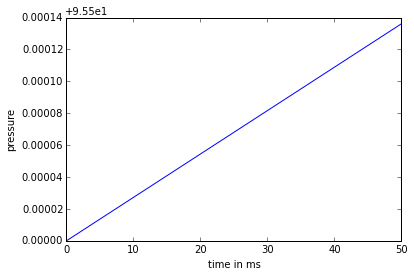

In [8]:
duration = 0.05
samples = freqToSampleNaive(freq,duration)

ms = linspace(0,duration*1000,44100*duration)

plt.plot(ms,samples)
plt.xlabel('time in ms')
plt.ylabel('pressure')
plt.show()

### $soundToSample$ <-> $sampleToSound$

In [9]:
filename = 'filename.wav'
samples, framerate = soundToSample(filename)
sampleToSound(samples, framerate, 'new.wav')

This code should generate a copy of your wav-file 'filename.wav' under the new name 'new.wav'

## experimenting with images

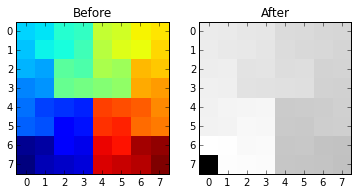

In [10]:
A = array([
       [21., 22., 25., 26., 37., 38., 41., 42.],
       [20., 23., 24., 27., 36., 39., 40., 43.],
       [19., 18., 29., 28., 35., 34., 45., 44.],
       [16., 17., 30., 31., 32., 33., 46., 47.],
       [15., 12., 11., 10., 53., 52., 51., 48.],
       [14., 13., 8., 9, 54., 55., 50., 49.],
       [1., 2., 7., 6., 57., 56., 61., 62.],
       [0., 3., 4., 5., 58., 59., 60., 63.]
       ], dtype=float32)

image = zeros([8,8,3])
image[:,:,0] = A*(63/63)
image[:,:,1] = A*(63/63)
image[:,:,2] = A*(63/63)

fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.imshow(A, interpolation='nearest')
a.set_title('Before')
a=fig.add_subplot(1,2,2)
a.set_title('After')
plt.imshow(image, interpolation='nearest')